In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from keras.models import load_model
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
look_back = 40
forward_days = 10
num_periods = 20

In [5]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2019-04-12,5061.20,5103.27,4955.85,5089.54,13675206312,89792633045
1,2019-04-11,5325.08,5354.23,5017.30,5064.49,16555616019,89341168457
2,2019-04-10,5204.11,5421.65,5193.38,5324.55,15504590933,93918439274
3,2019-04-09,5289.92,5289.92,5167.42,5204.96,14722104361,91799330425
4,2019-04-08,5199.84,5318.84,5148.21,5289.77,17154113634,93286365973


In [6]:
df = pd.DataFrame(bitcoin_market_info[['Close','Date']])
df.set_index('Date', inplace=True)
df = df.sort_index()

In [7]:
len(df)

2176

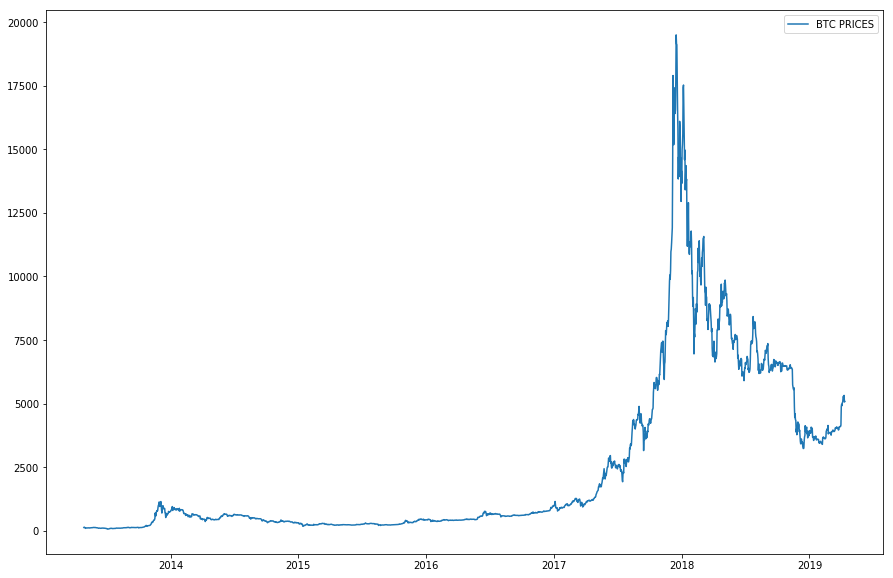

In [8]:
plt.figure(figsize = (15,10))
plt.plot(df, label='BTC PRICES')
plt.legend(loc='best')
plt.show()

In [9]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]

In [10]:
#EMA 
#Initial SMA: 10-period sum / 10 
#Multiplier: (2 / (Time periods + 1) ) = (2 / (10 + 1) ) = 0.1818 (18.18%)
#EMA: {Close - EMA(previous day)} x multiplier + EMA(previous day). 

df['EMA_DayByDay'] = np.NaN

window_size = 10
multiplier = 2 / (window_size + 1)  

#for the first value we use the SMA
window = make_window(window_size, 0)
EMA_prev = df['Close'].iloc[window].mean(axis=0)
df.iat[window_size, df.columns.get_loc('EMA_DayByDay')] = EMA_prev
df

for index in range(window_size+1, len(df)):
    EMA = (df['Close'].iloc[index-1] - EMA_prev) * multiplier + EMA_prev
    df.iat[index, df.columns.get_loc('EMA_DayByDay')] = EMA
    EMA_prev = EMA

df

,Close,EMA_DayByDay
Date,,
2013-04-28,134.21,NaN
2013-04-29,144.54,NaN
2013-04-30,139.00,NaN
2013-05-01,116.99,NaN
2013-05-02,105.21,NaN
2013-05-03,97.75,NaN
2013-05-04,112.50,NaN
2013-05-05,115.91,NaN
2013-05-06,112.30,NaN


In [11]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
df = df.fillna(0)
x = df.values #returns a numpy array    
array = scl.fit_transform(x)
array

array([[0.00338567, 0.        ],
       [0.00391735, 0.        ],
       [0.0036322 , 0.        ],
       ...,
       [0.27053004, 0.28135983],
       [0.25714487, 0.28560256],
       [0.25843418, 0.2863681 ]])

In [12]:
division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [13]:
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [14]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])
y_test
X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1541, 40, 2)
(386, 40, 2)
(20, 40, 2)
(1541, 20)
(386, 20)
(20, 20)


# Training LSTM

In [16]:
model = load_model('./LSTM_CP_EMA.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 40, 50)            10600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
Total params: 20,940
Trainable params: 20,940
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,2), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,2)))
model.add(Dropout(0.25))
model.add(Dense(forward_days*2))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 1535 samples, validate on 384 samples
Epoch 1/50
 - 63s - loss: 0.0070 - val_loss: 0.0013
Epoch 2/50
 - 64s - loss: 0.0031 - val_loss: 0.0013
Epoch 3/50
 - 62s - loss: 0.0027 - val_loss: 9.3031e-04
Epoch 4/50
 - 58s - loss: 0.0020 - val_loss: 8.3320e-04
Epoch 5/50
 - 58s - loss: 0.0018 - val_loss: 7.3554e-04
Epoch 6/50
 - 58s - loss: 0.0019 - val_loss: 7.1865e-04
Epoch 7/50
 - 58s - loss: 0.0017 - val_loss: 0.0010
Epoch 8/50
 - 58s - loss: 0.0017 - val_loss: 0.0026
Epoch 9/50
 - 58s - loss: 0.0018 - val_loss: 6.5352e-04
Epoch 10/50
 - 58s - loss: 0.0016 - val_loss: 9.0860e-04
Epoch 11/50
 - 58s - loss: 0.0020 - val_loss: 7.1026e-04
Epoch 12/50
 - 58s - loss: 0.0016 - val_loss: 5.1134e-04
Epoch 13/50
 - 58s - loss: 0.0016 - val_loss: 5.2528e-04
Epoch 14/50
 - 58s - loss: 0.0015 - val_loss: 4.6719e-04
Epoch 15/50
 - 58s - loss: 0.0016 - val_loss: 7.0007e-04
Epoch 16/50
 - 58s - loss: 0.0015 - val_loss: 6.1305e-04
Epoch 17/50
 - 58s - loss: 0.0016 - val_loss: 4.5958e-04
Epoch 18/

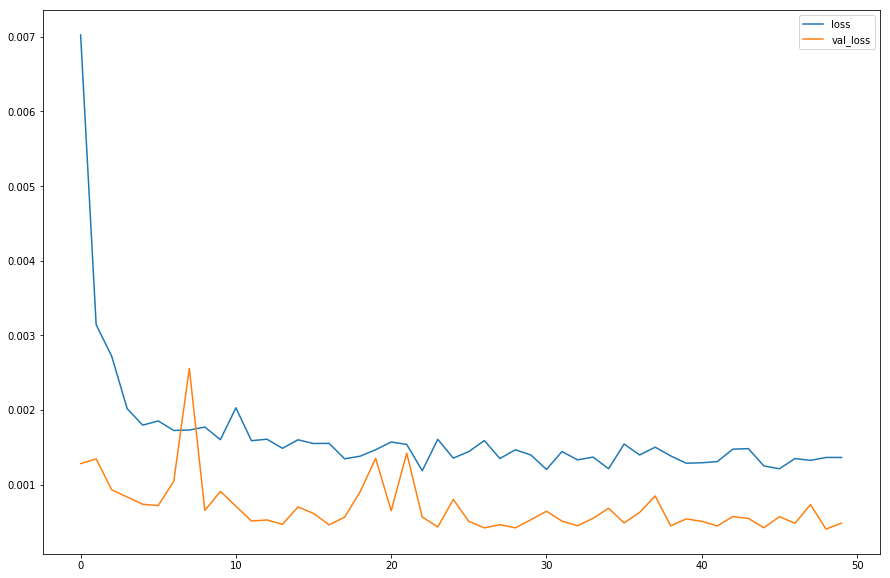

In [38]:
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [39]:
#Saving the model
file_name = './LSTM_CP_EMA.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `./LSTM_with_derived_features.h5` to disk


In [40]:
Xt = model.predict(X_test)

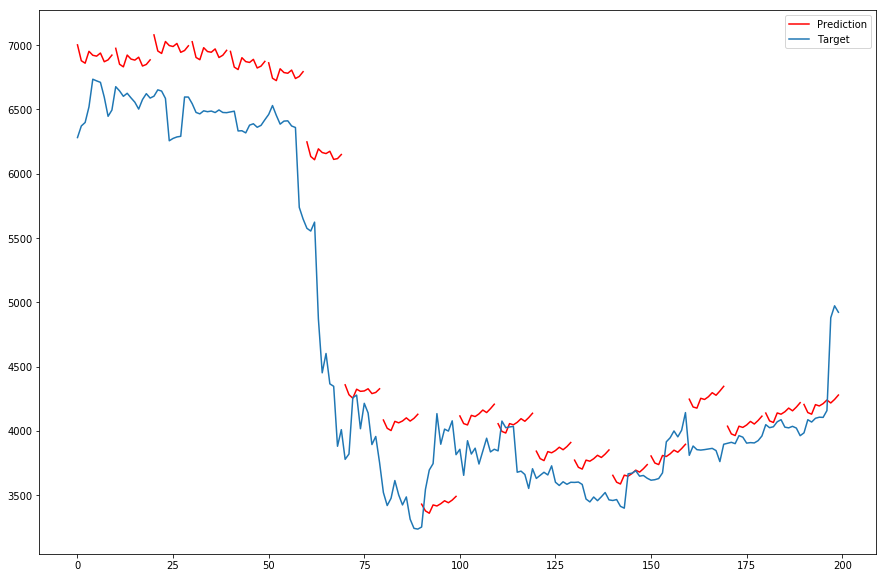

In [101]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i][0::2]))], [i[0] for i in scl.inverse_transform(Xt[i].reshape(-1,2))], color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,2))[0][0], color='r', label='Prediction') #only to place the label
plt.plot([i[0] for i in scl.inverse_transform(y_test.reshape(-1,2))], label='Target')
plt.legend(loc='best')
plt.show()

In [41]:
#Mean absolute error
mae_values=[]
for i,v in enumerate(Xt):
    prediction = scl.inverse_transform(np.array(np.reshape(Xt[i], (-1, 2))))
    actual = scl.inverse_transform(np.array(np.reshape(y_test[i], (-1, 2))))
    predictions = np.array([i[0] for i in prediction])
    actuals = np.array([i[0] for i in actual])
    print("Predicted:"+ str(np.where(predictions==min(predictions))[0][0])+"----Actual:"+ str(np.where(actuals==min(actuals))[0][0]))
    mae = (abs(predictions - actuals)).mean()
    mae_values.append(mae)

print("MAE: "+ str(np.mean(mae_values)))

Predicted:2----Actual:0
Predicted:2----Actual:6
Predicted:2----Actual:4
Predicted:2----Actual:2
Predicted:2----Actual:4
Predicted:2----Actual:9
Predicted:2----Actual:8
Predicted:2----Actual:9
Predicted:2----Actual:9
Predicted:2----Actual:0
Predicted:2----Actual:1
Predicted:2----Actual:8
Predicted:2----Actual:6
Predicted:2----Actual:4
Predicted:2----Actual:3
Predicted:2----Actual:0
Predicted:2----Actual:8
Predicted:2----Actual:2
Predicted:2----Actual:9
Predicted:2----Actual:0
MAE: 380.3250916503906
